# Lesson 28: TensorFlow/Keras neural network demonstration - part 2

## Notebook set up

### Imports

In [1]:
# Third party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

### GPU configuration

In [2]:
# Configure GPU settings
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        # Use only GPU 0
        tf.config.set_visible_devices(gpus[0], 'GPU')

        # Enable memory growth
        tf.config.experimental.set_memory_growth(gpus[0], True)

        print(f'Using GPU: {gpus[0]}')
        print('Memory growth enabled')

    except RuntimeError as e:
        print(e)

Using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Memory growth enabled


## 1. Load California housing data

Load the preprocessed data from part 1 of the demo:

In [3]:
data = pd.read_pickle('https://gperdrizet.github.io/FSA_devops/assets/data/unit4/preprocessed_housing_data.pkl')
print(f'Data dictionary contains: {list(data.keys())}')

Data dictionary contains: ['training_df', 'testing_df', 'features', 'label', 'feature_scaler', 'label_scaler']


In [4]:
training_df = data['training_df']
testing_df = data['testing_df']
features = data['features']
label = data['label']

## 2. Build model

In [5]:
tf.random.set_seed(315)

model = keras.Sequential([
    layers.Input(shape=(8,)),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1)
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='mse',
    metrics=['mae']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                288       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 3

## 3. Train model

checkpoint = ModelCheckpoint(
filepath='best_model.keras',
monitor='val_loss',
save_best_only=True,
verbose=1
)

es_callback = EarlyStopping(
monitor='val_loss',
patience=5,
restore_best_weights=True,
verbose=1
)

In [6]:
history = model.fit(
    training_df[features],
    training_df[label],
    epochs=50,
    batch_size=128,
    validation_split=0.2,
    verbose=1
)

print('Training complete.')
print(f'Final training loss: {history.history["loss"][-1]:.4f}')
print(f'Final validation loss: {history.history["val_loss"][-1]:.4f}')

Epoch 1/50


I0000 00:00:1769476819.632648    4087 service.cc:145] XLA service 0x7b83e1d2f170 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1769476819.632813    4087 service.cc:153]   StreamExecutor device (0): NVIDIA RTX 1000 Ada Generation Laptop GPU, Compute Capability 8.9
I0000 00:00:1769476819.896699    4087 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


97/97 [==============================] - 36s 33ms/step - loss: 0.9577 - mae: 0.7777 - val_loss: 0.8685 - val_mae: 0.7270
Epoch 2/50
97/97 [==============================] - 2s 23ms/step - loss: 0.8311 - mae: 0.7140 - val_loss: 0.7374 - val_mae: 0.6591
Epoch 3/50
97/97 [==============================] - 2s 23ms/step - loss: 0.7149 - mae: 0.6569 - val_loss: 0.6104 - val_mae: 0.5947
Epoch 4/50
97/97 [==============================] - 2s 23ms/step - loss: 0.6496 - mae: 0.6247 - val_loss: 0.5295 - val_mae: 0.5451
Epoch 5/50
97/97 [==============================] - 2s 24ms/step - loss: 0.5967 - mae: 0.5928 - val_loss: 0.4808 - val_mae: 0.5197
Epoch 6/50
97/97 [==============================] - 2s 23ms/step - loss: 0.5585 - mae: 0.5731 - val_loss: 0.4546 - val_mae: 0.5036
Epoch 7/50
97/97 [==============================] - 2s 23ms/step - loss: 0.5341 - mae: 0.5559 - val_loss: 0.4359 - val_mae: 0.4865
Epoch 8/50
97/97 [==============================] - 2s 23ms/step - loss: 0.5199 - mae: 0.5438

## 4. Learning curves

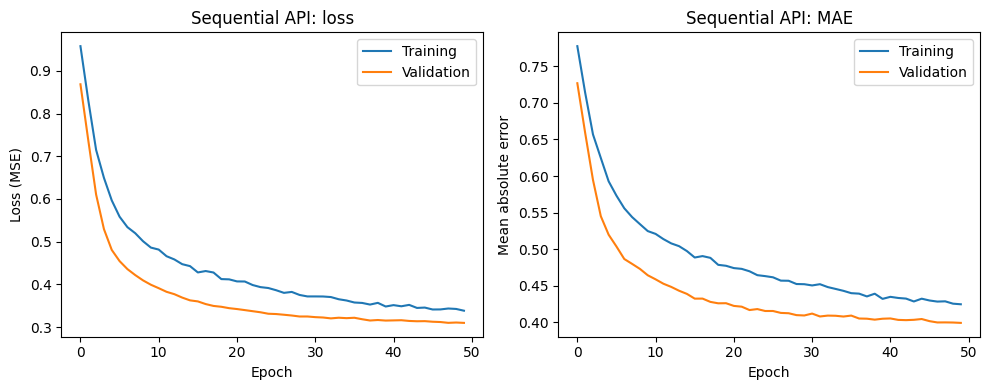

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].set_title('Sequential API: loss')
axes[0].plot(history.history['loss'], label='Training')
axes[0].plot(history.history['val_loss'], label='Validation')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].legend(loc='best')

axes[1].set_title('Sequential API: MAE')
axes[1].plot(history.history['mae'], label='Training')
axes[1].plot(history.history['val_mae'], label='Validation')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Mean absolute error')
axes[1].legend(loc='best')

plt.tight_layout()
plt.show()

## 5. Test set evaluation

In [8]:
predictions = model.predict(testing_df[features], verbose=0).flatten()

ss_res = np.sum((testing_df[label] - predictions) ** 2)
ss_tot = np.sum((testing_df[label] - np.mean(testing_df[label])) ** 2)
rsquared = 1 - (ss_res / ss_tot)

print(f'Model R² on test set: {rsquared:.4f}')

Model R² on test set: 0.7001


## 6. Performance analysis

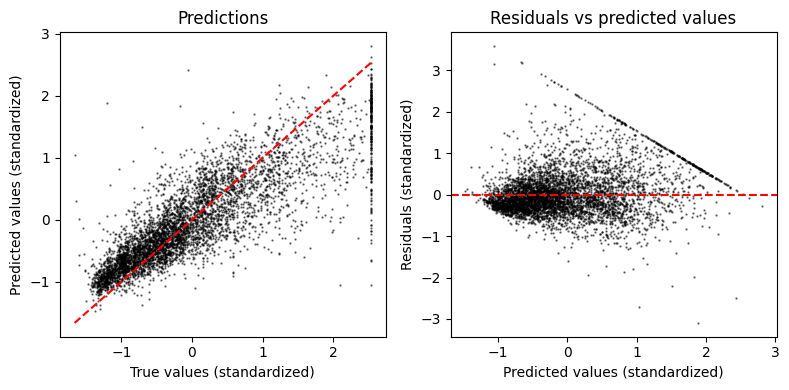

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].set_title('Predictions')
axes[0].scatter(
    testing_df[label], predictions,
    c='black', s=0.5, alpha=0.5
)

axes[0].plot(
    [testing_df[label].min(), testing_df[label].max()],
    [testing_df[label].min(), testing_df[label].max()],
    color='red', linestyle='--'
)

axes[0].set_xlabel('True values (standardized)')
axes[0].set_ylabel('Predicted values (standardized)')

axes[1].set_title('Residuals vs predicted values')
axes[1].scatter(
    predictions, testing_df[label] - predictions,
    c='black', s=0.5, alpha=0.5
)

axes[1].axhline(0, color='red', linestyle='--')
axes[1].set_xlabel('Predicted values (standardized)')
axes[1].set_ylabel('Residuals (standardized)')

plt.tight_layout()
plt.show()